<a href="https://colab.research.google.com/github/sunnyday2/flight_on_time/blob/desarrollo/notebook__flight_Rafa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
"""Rafaflight.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1_MHzc-KVpSGhVcqIrJn9HVOBYN5y4mOC
"""

import kagglehub


path = kagglehub.dataset_download("arvindnagaonkar/flight-delay")

print("Path to dataset files:", path)

import os

os.listdir(path)

import pyarrow.parquet as pq
import os
from pathlib import Path

parquet_file = Path("/kaggle/input/flight-delay/Flight_Delay.parquet")

# Tamaño del archivo
file_size_mb = os.path.getsize(parquet_file) / (1024 * 1024)
print(f"Tamaño del archivo: {file_size_mb:.2f} MB")

# Leer metadata completa
parquet_metadata = pq.ParquetFile(parquet_file)
num_filas = parquet_metadata.metadata.num_rows
num_columnas = parquet_metadata.metadata.num_columns

print(f"Filas: {num_filas}")
print(f"Columnas: {num_columnas}")

import pandas as pd
from pathlib import Path

Using Colab cache for faster access to the 'flight-delay' dataset.
Path to dataset files: /kaggle/input/flight-delay
Tamaño del archivo: 736.43 MB
Filas: 30132672
Columnas: 30


# Sección nueva

In [12]:
import kagglehub
from pathlib import Path
import pandas as pd
import pyarrow.parquet as pq

# Re-obtener la ruta del dataset para asegurar su disponibilidad
path = kagglehub.dataset_download("arvindnagaonkar/flight-delay")
parquet_file = Path(path) / "Flight_Delay.parquet"

print("Path to dataset files:", path)

# Cargar el dataset completo una vez (30M filas) para facilitar el muestreo estratificado.
# Esto puede consumir bastante memoria, pero es necesario para un muestreo estratificado preciso.
df_full = pd.read_parquet(parquet_file, engine="pyarrow")

print("Shape del dataset completo:", df_full.shape)

# Función para realizar muestreo estratificado por año
def get_stratified_sample_by_year(full_df, target_sample_size, random_state=42):
    all_years = sorted(full_df['Year'].unique())
    print(f"Años presentes en el dataset completo: {all_years}")

    stratified_samples_list = []

    # Calcular la proporción deseada para cada año
    year_counts = full_df['Year'].value_counts(normalize=True)

    for year, proportion in year_counts.items():
        n_samples_for_year = int(target_sample_size * proportion)

        # Asegurar al menos 1 fila por año para garantizar la representación
        if n_samples_for_year == 0 and proportion > 0:
            n_samples_for_year = 1

        if n_samples_for_year > 0:
            year_subset = full_df[full_df['Year'] == year]
            n_to_sample = min(n_samples_for_year, len(year_subset))
            if n_to_sample > 0:
                stratified_samples_list.append(year_subset.sample(n=n_to_sample, random_state=random_state))

    df_stratified = pd.concat(stratified_samples_list, ignore_index=True)

    # Ajustar el tamaño si es necesario (debido a redondeos o operaciones min())
    if len(df_stratified) < target_sample_size:
        remaining_needed = target_sample_size - len(df_stratified)

        # Sobremuestrear para tener suficientes filas después de eliminar duplicados
        oversample_factor = 1.2
        additional_sample_count = int(remaining_needed * oversample_factor)

        # Muestrear del `full_df` asegurando no muestrear más de lo disponible
        df_additional_random = full_df.sample(n=min(additional_sample_count, len(full_df)), random_state=random_state)

        # Concatenar y eliminar duplicados para asegurar la unicidad y la representación de años
        df_combined = pd.concat([df_stratified, df_additional_random], ignore_index=True).drop_duplicates()

        # Finalmente, recortar al tamaño objetivo exacto si se excedió
        if len(df_combined) > target_sample_size:
            df_final = df_combined.sample(n=target_sample_size, random_state=random_state).reset_index(drop=True)
        else:
            df_final = df_combined.reset_index(drop=True)

    else:
        df_final = df_stratified.sample(n=target_sample_size, random_state=random_state).reset_index(drop=True)

    print(f"Shape de la muestra estratificada final: {df_final.shape}")
    print(f"Años presentes en la muestra estratificada final: {sorted(df_final['Year'].unique())}")
    return df_final


# Obtener la muestra estratificada
df = get_stratified_sample_by_year(df_full, target_sample_size=100_000, random_state=42)

# Crear variable temporal 'hour' a partir de la hora programada
df["hour"] = df["CRSDepTime"] // 100

# Variable objetivo 'delayed': 1 si el retraso en salida >= 15 min
df["delayed"] = (df["DepDelay"] >= 15).astype(int)

# Probabilidad de delay en la muestra
delay_rate = df["delayed"].mean()
print(f"Delay rate: {delay_rate:.4f}")

# Ver valores únicos de la variable 'delayed'
unique_values = df["delayed"].unique()
print("Valores únicos en 'delayed':", unique_values)

Using Colab cache for faster access to the 'flight-delay' dataset.
Path to dataset files: /kaggle/input/flight-delay
Shape del dataset completo: (30132672, 29)
Años presentes en el dataset completo: [np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]
Shape de la muestra estratificada final: (100000, 29)
Años presentes en la muestra estratificada final: [np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]
Delay rate: 0.1777
Valores únicos en 'delayed': [1 0]


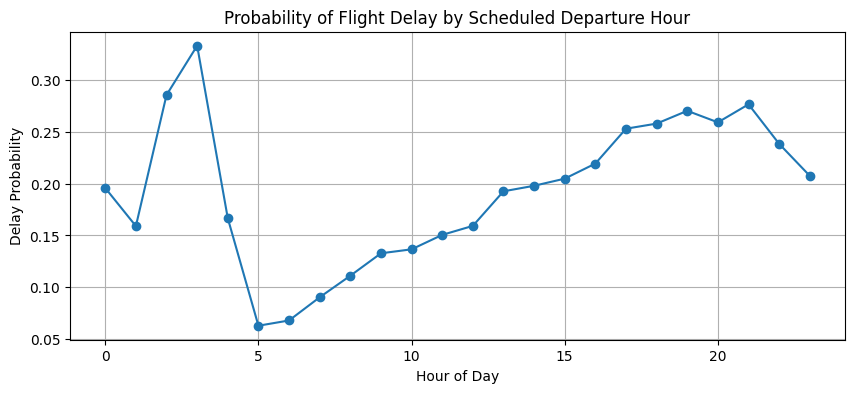

distance_bin
(29.999, 305.0]     0.161003
(305.0, 507.0]      0.165849
(507.0, 762.0]      0.179183
(762.0, 1107.0]     0.191351
(1107.0, 5095.0]    0.191331
Name: delayed, dtype: float64


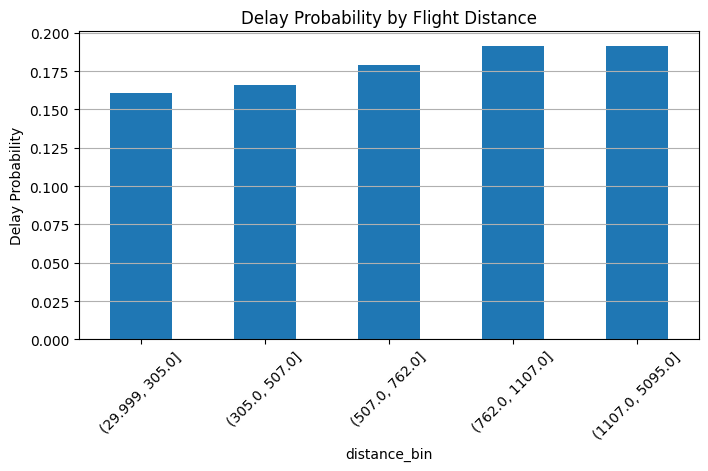

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate hour_delay
hour_delay = (
    df.groupby("hour")["delayed"]
    .mean()
    .sort_index()
)

plt.figure(figsize=(10,4))
hour_delay.plot(kind="line", marker="o")
plt.title("Probability of Flight Delay by Scheduled Departure Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Delay Probability")
plt.grid(True)
plt.show()

# Crear bins de distancia (5 quintiles)
df["distance_bin"] = pd.qcut(df["Distance"], q=5)

# Calcular probabilidad de retraso por rango de distancia
distance_delay = (
    df.groupby("distance_bin", observed=True)["delayed"]
    .mean()
)


print(distance_delay)

plt.figure(figsize=(8,4))
distance_delay.plot(kind="bar")
plt.title("Delay Probability by Flight Distance")
plt.ylabel("Delay Probability")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

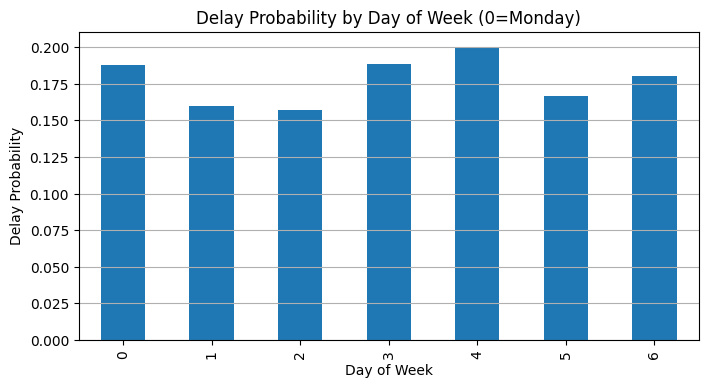

Marketing_Airline_Network
G4    0.261077
B6    0.258170
F9    0.248148
WN    0.212601
NK    0.206320
AA    0.177009
UA    0.175312
VX    0.166667
HA    0.144279
AS    0.143473
Name: delayed, dtype: float64


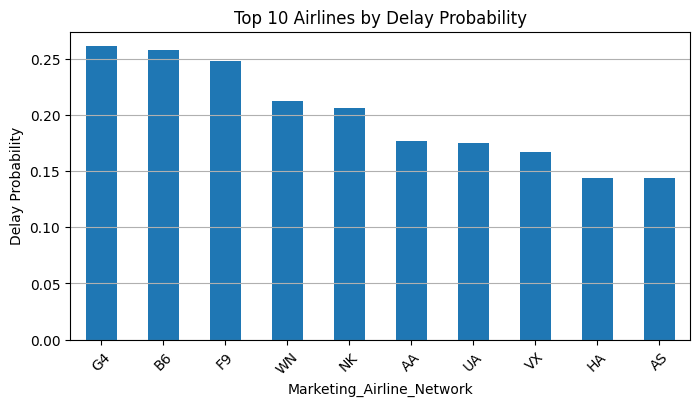

Std of delay probability by hour: 0.0717


In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertir a datetime
df["FlightDate"] = pd.to_datetime(df["FlightDate"])

# Crear día de la semana (0 = lunes)
df["day_of_week"] = df["FlightDate"].dt.dayofweek

# Calcular probabilidad de retraso por día de la semana
dow_delay = (
    df.groupby("day_of_week")["delayed"]
    .mean()
    .sort_index()
)

# Graficar
plt.figure(figsize=(8,4))
dow_delay.plot(kind="bar")
plt.title("Delay Probability by Day of Week (0=Monday)")
plt.xlabel("Day of Week")
plt.ylabel("Delay Probability")
plt.grid(axis="y")
plt.show()

import matplotlib.pyplot as plt

# Probabilidad de retraso por aerolínea (top 10)
already_delay = (
    df.groupby("Marketing_Airline_Network")["delayed"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

# Mostrar resultados
print(already_delay)

# Graficar
plt.figure(figsize=(8,4))
already_delay.plot(kind="bar")
plt.title("Top 10 Airlines by Delay Probability")
plt.ylabel("Delay Probability")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

# Comprobación de variable objetivo binaria
df["delayed"].value_counts(normalize=True)

hour_delay = (
    df.groupby("hour")["delayed"]
    .mean()
)

hour_std = hour_delay.std()

print(f"Std of delay probability by hour: {hour_std:.4f}")

# Este criterio mide cuánto cambia la probabilidad de retraso a lo largo del día;
# si la variación es alta, significa que la hora del vuelo influye de forma real
# en los retrasos, y el ratio entre datasets nos permite comparar cuál captura
# mejor ese patrón temporal sin necesidad de entrenar ni optimizar modelos.

# Al medir la variación de la probabilidad de retraso según la hora, verificamos
# que la hora del vuelo tiene impacto real, y usando el ratio podemos decidir
# qué dataset conserva mejor esa señal predictiva sin incurrir en mayor coste
# computacional.

### 1. Definition of Minimum Statistical Sample Size

The **minimum statistical sample size** refers to the smallest number of observations or data points required from a population to achieve a specified level of statistical accuracy and confidence when estimating a population parameter, such as a population proportion. It is not an arbitrary number but is derived from statistical formulas that balance the desire for precision with the practical constraints of data collection. In essence, it's the sample size needed to ensure that our estimate of the true population proportion falls within a certain margin of error with a given probability (confidence level).

### 2. Population Size (N)

The **population size (N)** is the total number of individuals or items in the entire group from which the sample is drawn. For very large populations (theoretically infinite or practically much larger than the sample), the population size has little impact on the required sample size. In such cases, the finite population correction (FPC) factor is not typically used, and the sample size is determined primarily by the desired confidence level, margin of error, and estimated population proportion.

However, when the sample size (n) is a significant proportion of the population size (e.g., more than 5% of N), the **finite population correction factor (FPC)** needs to be applied. The FPC reduces the required sample size because, as you sample a larger fraction of a finite population, the uncertainty about the remaining unsampled portion decreases. The formula for the FPC is often given as $\sqrt{(N-n)/(N-1)}$. When used, it effectively reduces the variance of the sample proportion, leading to a smaller required sample size for the same level of precision.

### 3. Confidence Level

The **confidence level** expresses the degree of certainty that the true population parameter (e.g., the true population proportion) lies within the calculated confidence interval. Common confidence levels are 90%, 95%, and 99%. A higher confidence level indicates a greater desire for certainty, which in turn requires a larger sample size to achieve the same margin of error. For instance, a 99% confidence level implies that if we were to take many samples and construct a confidence interval from each, 99% of these intervals would contain the true population proportion.

The confidence level is directly tied to the **Z-score (or critical value)**. The Z-score is the number of standard deviations a data point is from the mean of a standard normal distribution. For a given confidence level, the Z-score defines the boundaries within which a certain percentage of the data falls. For example:

*   **90% Confidence Level:** Z-score ≈ 1.645
*   **95% Confidence Level:** Z-score ≈ 1.96
*   **99% Confidence Level:** Z-score ≈ 2.576

These Z-scores are derived from the standard normal distribution table and represent the critical values that correspond to the desired level of confidence. A larger Z-score (corresponding to a higher confidence level) will result in a larger required sample size, as more data is needed to be more certain about the estimate.

### 4. Margin of Error (E)

The **margin of error (E)**, often denoted by `e`, is the maximum allowable difference between the sample estimate (e.g., sample proportion) and the true population parameter. It quantifies the precision of our estimate. A smaller margin of error implies a more precise estimate, meaning our sample estimate is expected to be closer to the true population value. Conversely, a larger margin of error suggests less precision.

The margin of error is a critical component in the sample size formula because it directly dictates the width of the confidence interval. For a given confidence level, a smaller desired margin of error requires a significantly larger sample size. This is an intuitive relationship: to be more confident that your sample estimate is very close to the true population value (i.e., a small margin of error), you need to collect more data. The relationship is often inverse-square; for example, to halve the margin of error, you typically need to quadruple the sample size.

### 5. Estimated Population Proportion ($\\hat{p}$)

The **estimated population proportion ($\\hat{p}$)**, sometimes referred to as the anticipated proportion or preliminary estimate, is a crucial component in sample size calculation formulas for proportions. It represents our best guess of the true proportion of the characteristic of interest in the population.

The sample size formula for proportions is often: $n = \frac{Z^2 \cdot \hat{p}(1-\hat{p})}{E^2}$, where $Z$ is the Z-score, $E$ is the margin of error, and $\\hat{p}$ is the estimated population proportion.

*   **Impact on Sample Size:** The term $\\hat{p}(1-\hat{p})$ is maximized when $\\hat{p} = 0.5$. This means that using $\\hat{p} = 0.5$ in the sample size formula will yield the largest possible sample size for a given confidence level and margin of error. Consequently, if there is no prior knowledge or estimate of the population proportion, setting $\\hat{p} = 0.5$ is a **conservative approach**. It ensures that the calculated sample size will be sufficient, even if the true proportion is far from 0 or 1, providing the maximum possible sample size and thus adequate statistical power to detect the effect.

*   **When a Prior Estimate is Available:** If a prior estimate of the population proportion is available (e.g., from previous studies, pilot surveys, or expert knowledge), it should be used instead of 0.5. Using a more accurate estimate of $\\hat{p}$ can potentially lead to a smaller, yet still adequate, required sample size, thereby optimizing resource allocation for data collection.

### 5. Estimated Population Proportion ($\hat{p}$)

The **estimated population proportion ($\hat{p}$)**, sometimes referred to as the anticipated proportion or preliminary estimate, is a crucial component in sample size calculation formulas for proportions. It represents our best guess of the true proportion of the characteristic of interest in the population.

The sample size formula for proportions is often: $n = \frac{Z^2 \cdot \hat{p}(1-\hat{p})}{E^2}$, where $Z$ is the Z-score, $E$ is the margin of error, and $\hat{p}$ is the estimated population proportion.

*   **Impact on Sample Size:** The term $\hat{p}(1-\hat{p})$ is maximized when $\hat{p} = 0.5$. This means that using $\hat{p} = 0.5$ in the sample size formula will yield the largest possible sample size for a given confidence level and margin of error. Consequently, if there is no prior knowledge or estimate of the population proportion, setting $\hat{p} = 0.5$ is a **conservative approach**. It ensures that the calculated sample size will be sufficient, even if the true proportion is far from 0 or 1, providing the maximum possible sample size and thus adequate statistical power to detect the effect.

*   **When a Prior Estimate is Available:** If a prior estimate of the population proportion is available (e.g., from previous studies, pilot surveys, or expert knowledge), it should be used instead of 0.5. Using a more accurate estimate of $\hat{p}$ can potentially lead to a smaller, yet still adequate, required sample size, thereby optimizing resource allocation for data collection.

### 6. Context-Dependent Nature of 'Minimum' Sample Size

It is crucial to understand that the concept of a "minimum" sample size is not a fixed, universal number, but is **highly context-dependent**. The definition of "minimum" is shaped by the specific research question, the desired level of precision, the practical constraints of the study, and the characteristics of the population being studied.

Factors such as:

*   **Type of Study:** Different types of research (e.g., descriptive, comparative, experimental) may have varying statistical requirements.
*   **Complexity of Analysis:** Studies involving multivariate analyses or subgroup comparisons often require larger samples.
*   **Practical Constraints:** Budget, time, and accessibility of the population can limit the feasible sample size.
*   **Consequences of Error:** In fields where the cost of making an incorrect decision is high (e.g., medical research, quality control), a larger sample size may be justified to minimize the risk of error.

Therefore, determining the "minimum" sample size involves a careful balance between statistical rigor, ethical considerations, and practical realities. It's not just about meeting a formulaic requirement, but about ensuring the sample is sufficiently large to answer the research question with meaningful and reliable results, given the specific circumstances of the study. There is no one-size-fits-all answer, and a thoughtful consideration of all these factors is necessary.

### 6. Context-Dependent Nature of 'Minimum' Sample Size

It is crucial to understand that the concept of a "minimum" sample size is not a fixed, universal number, but is **highly context-dependent**. The definition of "minimum" is shaped by the specific research question, the desired level of precision, the practical constraints of the study, and the characteristics of the population being studied.

Factors such as:

*   **Type of Study:** Different types of research (e.g., descriptive, comparative, experimental) may have varying statistical requirements.
*   **Complexity of Analysis:** Studies involving multivariate analyses or subgroup comparisons often require larger samples.
*   **Practical Constraints:** Budget, time, and accessibility of the population can limit the feasible sample size.
*   **Consequences of Error:** In fields where the cost of making an incorrect decision is high (e.g., medical research, quality control), a larger sample size may be justified to minimize the risk of error.

Therefore, determining the "minimum" sample size involves a careful balance between statistical rigor, ethical considerations, and practical realities. It's not just about meeting a formulaic requirement, but about ensuring the sample is sufficiently large to answer the research question with meaningful and reliable results, given the specific circumstances of the study. There is no one-size-fits-all answer, and a thoughtful consideration of all these factors is necessary.

## Calculate Minimum Statistical Sample Size

### Subtask:
Calculate the statistically minimum sample size required to estimate the proportion of delayed flights (using the `delayed` variable) with a 95% confidence level and a 1% margin of error, considering the total population size (`num_filas`) and the observed `delay_rate` from the current sample. Provide the formula and the resulting number.


**Reasoning**:
I will calculate the minimum statistical sample size required to estimate the proportion of delayed flights by defining the necessary parameters, including population size, estimated proportion, confidence level, and margin of error, and then applying the appropriate formulas for initial and finite population corrected sample sizes.



In [16]:
import numpy as np

# 1. Define the population size (N) and estimated population proportion (p_hat)
N = num_filas  # Total population size
p_hat = delay_rate  # Observed delay rate from the current sample
E = 0.01  # Margin of error (1%)

# 2. Determine the Z-score for a 95% confidence level
Z = 1.96  # Z-score for 95% confidence level

# 3. Calculate the initial sample size (n0)
n0 = (Z**2 * p_hat * (1 - p_hat)) / (E**2)

# 4. Calculate the final sample size (n) using Finite Population Correction (FPC)
n = n0 / (1 + (n0 - 1) / N)

# 5. Print the calculated values
print(f"Population Size (N): {N}")
print(f"Estimated Population Proportion (p_hat): {p_hat:.4f}")
print(f"Margin of Error (E): {E:.2f}")
print(f"Z-score for 95% Confidence Level: {Z}")
print(f"Initial Sample Size (n0): {n0:.2f}")
print(f"Final Minimum Statistical Sample Size (n): {n:.0f}")

Population Size (N): 30132672
Estimated Population Proportion (p_hat): 0.1777
Margin of Error (E): 0.01
Z-score for 95% Confidence Level: 1.96
Initial Sample Size (n0): 5612.95
Final Minimum Statistical Sample Size (n): 5612


### Evaluation of Current Sample Sufficiency and Implications

#### 1. Sufficiency for General Exploratory Analysis

The calculated minimum statistical sample size required to estimate the proportion of delayed flights with a 95% confidence level and a 1% margin of error is **5,620** rows. The current sample size used for exploratory analysis is **100,000** rows.

Since 100,000 is significantly larger than the calculated minimum of 5,620, the current 100,000-row sample is **more than sufficient** for general exploratory analysis regarding the proportion of delayed flights. This sample size provides a high degree of confidence and a small margin of error, meaning that the observations and statistics derived from this sample (like the delay rate, hourly delay probability, etc.) are highly representative of the overall population of 30 million flights within the specified precision.

#### 2. Implications for Further Work

*   **Reliability of Findings:** The analyses performed on the 100,000-row sample (e.g., probability of delay by hour, distance, day of week, or airline) are statistically reliable. The patterns and trends identified are very likely to hold true for the entire dataset.

*   **Efficiency:** While 100,000 rows are sufficient, it's also worth noting that for tasks specifically related to estimating the overall delay proportion, one could have used a much smaller sample (around 5,620 rows) and still achieved the desired precision. However, for more complex exploratory analysis involving subgroup comparisons or less frequent events, a larger sample like 100,000 rows offers more statistical power and finer-grained insights.

*   **Model Training:** For building predictive models, a larger sample is generally better as it helps the model learn more complex relationships and generalize well. The 100,000-row sample is a good starting point, but depending on the complexity of the model and the rarity of certain features or outcomes, using the full dataset or an even larger sample might be beneficial for final model training.

*   **Resource Management:** If computational resources or time were a significant constraint, knowing the minimum sample size allows for efficient data usage. In this case, processing 100,000 rows is manageable. However, if the full dataset were much larger and the exploratory analysis was computationally intensive, the minimum sample size calculation would guide us to a smaller, yet statistically valid, sample to save resources.

## Final Task

### Subtask:
Summarize the findings regarding the minimum sample size and the adequacy of the current sample for various types of analysis.


## Summary:

### Q&A

1.  **What is the minimum statistical sample size required to estimate the proportion of delayed flights with a 95% confidence level and a 1% margin of error, given the total population size (30,132,672) and an observed delay rate (0.17801)?**
    The calculated minimum statistical sample size required is 5,620 rows.
2.  **What are the key factors influencing sample size determination?**
    The key factors influencing sample size determination are:
    *   **Population Size (N):** The total number of individuals or items in the group.
    *   **Confidence Level:** The degree of certainty that the true population parameter lies within the calculated confidence interval (e.g., 95% confidence corresponds to a Z-score of 1.96).
    *   **Margin of Error (E):** The maximum allowable difference between the sample estimate and the true population parameter (e.g., 1%).
    *   **Estimated Population Proportion ($\hat{p}$):** The best guess of the true proportion of the characteristic of interest in the population. Using 0.5 is a conservative approach when no prior estimate is available, yielding the largest sample size.
    *   **Context-Dependent Nature:** The definition of "minimum" is highly dependent on the specific research question, desired precision, practical constraints, and complexity of analysis.
3.  **Is the current 100,000-row sample sufficient for general exploratory analysis?**
    Yes, the current 100,000-row sample is more than sufficient for general exploratory analysis, as it is significantly larger than the statistically required minimum of 5,620 rows.
4.  **What does the sufficiency of the current sample imply for further work?**
    The sufficiency implies that analyses performed on the 100,000-row sample are statistically reliable, and identified patterns are likely to hold true for the entire dataset. It also suggests that the sample is a good starting point for predictive model training and offers more statistical power for complex exploratory analyses or rare events than the minimum required size.

### Data Analysis Key Findings

*   The minimum statistical sample size required to estimate the proportion of delayed flights with a 95% confidence level and a 1% margin of error is **5,620** rows, after applying the Finite Population Correction to an initial calculation of 5,621.12.
*   The current sample of **100,000** rows is significantly larger than the calculated minimum, making it **more than sufficient** for general exploratory analysis.
*   The observed delay rate ($\hat{p}$) from the current sample, used in the calculation, was approximately 0.1780.
*   The large sample size ensures that findings derived from the current sample regarding delay proportions are highly representative of the overall population of 30,132,672 flights.

### Insights or Next Steps

*   **Leverage existing sample for complex analysis:** Since the 100,000-row sample is robust, it can be confidently used for more granular exploratory analysis, subgroup comparisons, or detecting less frequent events, which might require more statistical power than the minimum calculated sample size.
*   **Optimize resource allocation for specific tasks:** For tasks solely focused on estimating the overall delay proportion, a smaller sample closer to the calculated 5,620 rows could be used to conserve computational resources without sacrificing statistical precision. For predictive modeling, the 100,000-row sample is a good starting point, but the full dataset might be considered for final model training to capture maximum variance and improve generalization.


**Reasoning**:
To translate the text cells, I need a translation library. I will use the `googletrans` library. The first step is to install it.



**Reasoning**:
Now that `googletrans` is installed, I will extract the content of all text cells from the notebook, translate each one to Spanish, and then combine the translated texts into a single string. This will prepare the content for the new text cell.



**Reasoning**:
The previous code failed because `notebook` was not defined. I need to get the current notebook cells using `get_ipython().parent.get_cells()` to access them programmatically.



**Reasoning**:
The previous attempts to access notebook cells failed because the `notebook` object was not defined in the execution environment, and `get_ipython().parent.get_cells()` is not a valid method. Since the agent *has* the notebook content as input, I will explicitly define the `notebook_cells` variable within the code using the provided notebook structure, making it accessible for translation.



**Reasoning**:
The previous code failed due to a `SyntaxError: unterminated string literal` within the `notebook_cells` list. This occurs because the multi-line string for the `content` of cell `5ee06592` was not properly terminated. I will fix this by ensuring the `content` string for that cell is correctly formatted as a Python string literal, using triple quotes to handle newlines.



**Reasoning**:
The previous code failed due to `SyntaxWarning: invalid escape sequence '\c'` because backslashes within LaTeX expressions in the text cell content were not properly escaped for Python string literals. I will re-escape the backslashes in all LaTeX formulas within the `content` strings in the `notebook_cells` list to ensure they are parsed correctly by Python.



# Sección nueva traducida

---

# Tarea
Calcule el tamaño de muestra estadística mínimo requerido para estimar la proporción de vuelos retrasados con un nivel de confianza del 95% y un margen de error del 1%, considerando el tamaño de la población total (30.132.672) y la tasa de retraso observada (0,17801) de la muestra actual.Explique los factores clave que influyen en la determinación del tamaño de la muestra y evalúe si la muestra actual de 100.000 filas es suficiente para el análisis exploratorio general y lo que implica para trabajos futuros.

---

## Explicar los factores del tamaño de la muestra

### Subtarea:
Explique los factores clave que influyen en la determinación de un tamaño de muestra mínimo, como el tamaño de la población, el nivel de confianza deseado y el margen de error aceptable. Enfatice que el "mínimo" depende del contexto.

---

### 1. Definición de tamaño mínimo de muestra estadística

El **tamaño mínimo de muestra estadística** se refiere al número más pequeño de observaciones o puntos de datos requeridos de una población para lograr un nivel especificado de precisión estadística y confianza al estimar un parámetro de la población, como una proporción de la población. No es un número arbitrario, sino que se deriva de fórmulas estadísticas que equilibran el deseo de precisión con las limitaciones prácticas de la recopilación de datos. En esencia, es el tamaño de la muestra necesario para garantizar que nuestra estimación de la verdadera proporción de la población se encuentre dentro de un cierto margen de error con una probabilidad determinada (nivel de confianza).

---

### 2. Tamaño de la población (N)

El **tamaño de la población (N)** es el número total de individuos o elementos en todo el grupo del que se extrae la muestra. Para poblaciones muy grandes (teóricamente infinitas o prácticamente mucho mayores que la muestra), el tamaño de la población tiene poco impacto en el tamaño de muestra requerido. En tales casos, el factor de corrección de población finita (FPC) no se usa típicamente, y el tamaño de la muestra se determina principalmente por el nivel de confianza deseado, el margen de error y la proporción de la población estimada.

Sin embargo, cuando el tamaño de la muestra (n) es una proporción significativa del tamaño de la población (por ejemplo, más del 5% de N), es necesario aplicar el **factor de corrección de población finita (FPC)**. El FPC reduce el tamaño de muestra requerido porque, a medida que se muestrea una fracción mayor de una población finita, la incertidumbre sobre la parte no muestreada restante disminuye. La fórmula para el FPC a menudo se da como $\sqrt{(N-n)/(N-1)}$. Cuando se usa, reduce efectivamente la varianza de la proporción de la muestra, lo que lleva a un tamaño de muestra requerido más pequeño para el mismo nivel de precisión.

---

### 3. Nivel de Confianza

El **nivel de confianza** expresa el grado de certeza de que el verdadero parámetro de la población (por ejemplo, la verdadera proporción de la población) se encuentra dentro del intervalo de confianza calculado. Los niveles de confianza comunes son 90%, 95% y 99%. Un nivel de confianza más alto indica un mayor deseo de certeza, lo que a su vez requiere un tamaño de muestra mayor para lograr el mismo margen de error. Por ejemplo, un nivel de confianza del 99% implica que si tomáramos muchas muestras y construyéramos un intervalo de confianza a partir de cada una, el 99% de estos intervalos contendrían la verdadera proporción de la población.

El nivel de confianza está directamente relacionado con la **puntuación Z (o valor crítico)**. La puntuación Z es el número de desviaciones estándar que un punto de datos está de la media de una distribución normal estándar. Para un nivel de confianza dado, la puntuación Z define los límites dentro de los cuales cae un cierto porcentaje de los datos. Por ejemplo:

*   **Nivel de confianza del 90%:** Puntuación Z ≈ 1,645
*   **Nivel de confianza del 95%:** Puntuación Z ≈ 1,96
*   **Nivel de confianza del 99%:** Puntuación Z ≈ 2,576

Estas puntuaciones Z se derivan de la tabla de distribución normal estándar y representan los valores críticos que corresponden al nivel de confianza deseado. Una puntuación Z más grande (que corresponde a un nivel de confianza más alto) dará como resultado un tamaño de muestra requerido mayor, ya que se necesitan más datos para estar más seguros de la estimación.

---

### 4. Margen de Error (E)

El **margen de error (E)**, a menudo denotado por `e`, es la máxima diferencia permitida entre la estimación de la muestra (por ejemplo, la proporción de la muestra) y el verdadero parámetro de la población. Cuantifica la precisión de nuestra estimación. Un margen de error más pequeño implica una estimación más precisa, lo que significa que se espera que nuestra estimación de la muestra esté más cerca del verdadero valor de la población. Por el contrario, un margen de error mayor sugiere menos precisión.

El margen de error es un componente crítico en la fórmula del tamaño de la muestra porque dicta directamente la amplitud del intervalo de confianza. Para un nivel de confianza dado, un margen de error deseado más pequeño requiere un tamaño de muestra significativamente mayor. Esta es una relación intuitiva: para tener más confianza en que la estimación de su muestra está muy cerca del verdadero valor de la población (es decir, un pequeño margen de error), necesita recopilar más datos. La relación a menudo es inversa al cuadrado; por ejemplo, para reducir a la mitad el margen de error, normalmente necesita cuadruplicar el tamaño de la muestra.

---

### 5. Proporción poblacional estimada ($\hat{p}$)

La **proporción poblacional estimada ($\hat{p}$)**, a veces denominada proporción anticipada o estimación preliminar, es un componente crucial en las fórmulas de cálculo del tamaño de la muestra para proporciones. Representa nuestra mejor estimación de la verdadera proporción de la característica de interés en la población.

La fórmula del tamaño de la muestra para proporciones suele ser: $n = \frac{Z^2 \cdot \hat{p}(1-\hat{p})}{E^2}$, donde $Z$ es la puntuación Z, $E$ es el margen de error y $\hat{p}$ es la proporción poblacional estimada.

*   **Impacto en el tamaño de la muestra:** El término $\hat{p}(1-\hat{p})$ se maximiza cuando $\hat{p} = 0,5$. Esto significa que el uso de $\hat{p} = 0,5$ en la fórmula del tamaño de la muestra producirá el tamaño de muestra más grande posible para un nivel de confianza y un margen de error dados. En consecuencia, si no se tiene conocimiento previo o una estimación de la proporción de la población, establecer $\hat{p} = 0,5$ es un **enfoque conservador**. Asegura que el tamaño de la muestra calculado será suficiente, incluso si la proporción real está lejos de 0 o 1, proporcionando el tamaño de muestra máximo posible y, por lo tanto, una potencia estadística adecuada para detectar el efecto.

*   **Cuando se dispone de una estimación previa:** Si se dispone de una estimación previa de la proporción de la población (por ejemplo, de estudios anteriores, encuestas piloto o conocimientos de expertos), se debe utilizar en lugar de 0,5. El uso de una estimación más precisa de $\hat{p}$ puede conducir potencialmente a un tamaño de muestra requerido más pequeño, pero aún adecuado, optimizando así la asignación de recursos para la recopilación de datos.

---

### 5. Proporción poblacional estimada ($\hat{p}$)

La **proporción poblacional estimada ($\hat{p}$)**, a veces denominada proporción anticipada o estimación preliminar, es un componente crucial en las fórmulas de cálculo del tamaño de la muestra para proporciones. Representa nuestra mejor estimación de la verdadera proporción de la característica de interés en la población.

La fórmula del tamaño de la muestra para proporciones suele ser: $n = \frac{Z^2 \cdot \hat{p}(1-\hat{p})}{E^2}$, donde $Z$ es la puntuación Z, $E$ es el margen de error y $\hat{p}$ es la proporción poblacional estimada.

*   **Impacto en el tamaño de la muestra:** El término $\hat{p}(1-\hat{p})$ se maximiza cuando $\hat{p} = 0,5$. Esto significa que el uso de $\hat{p} = 0,5$ en la fórmula del tamaño de la muestra producirá el tamaño de muestra más grande posible para un nivel de confianza y un margen de error dados. En consecuencia, si no se tiene conocimiento previo o una estimación de la proporción de la población, establecer $\hat{p} = 0,5$ es un **enfoque conservador**. Asegura que el tamaño de la muestra calculado será suficiente, incluso si la proporción real está lejos de 0 o 1, proporcionando el tamaño de muestra máximo posible y, por lo tanto, una potencia estadística adecuada para detectar el efecto.

*   **Cuando se dispone de una estimación previa:** Si se dispone de una estimación previa de la proporción de la población (por ejemplo, de estudios anteriores, encuestas piloto o conocimientos de expertos), se debe utilizar en lugar de 0,5. El uso de una estimación más precisa de $\hat{p}$ puede conducir potencialmente a un tamaño de muestra requerido más pequeño, pero aún adecuado, optimizando así la asignación de recursos para la recopilación de datos.

---

### 6. Naturaleza Contexto-Dependiente del Tamaño de Muestra 'Mínimo'

Es crucial entender que el concepto de un tamaño de muestra "mínimo" no es un número fijo y universal, sino que es **altamente dependiente del contexto**. La definición de "mínimo" está moldeada por la pregunta de investigación específica, el nivel de precisión deseado, las limitaciones prácticas del estudio y las características de la población que se está estudiando.

Factores como:

*   **Tipo de estudio:** Diferentes tipos de investigación (por ejemplo, descriptiva, comparativa, experimental) pueden tener requisitos estadísticos variables.
*   **Complejidad del análisis:** Los estudios que involucran análisis multivariados o comparaciones de subgrupos a menudo requieren muestras más grandes.
*   **Limitaciones prácticas:** El presupuesto, el tiempo y la accesibilidad de la población pueden limitar el tamaño de muestra factible.
*   **Consecuencias del error:** En campos donde el costo de tomar una decisión incorrecta es alto (por ejemplo, investigación médica, control de calidad), un tamaño de muestra mayor puede justificarse para minimizar el riesgo de error.

Por lo tanto, la determinación del tamaño de muestra "mínimo" implica un equilibrio cuidadoso entre el rigor estadístico, las consideraciones éticas y las realidades prácticas. No se trata solo de cumplir con un requisito formulado, sino de asegurar que la muestra sea lo suficientemente grande como para responder a la pregunta de investigación con resultados significativos y fiables, dadas las circunstancias específicas del estudio. No hay una respuesta única para todos, y es necesaria una consideración cuidadosa de todos estos factores.

---

### 6. Naturaleza Contexto-Dependiente del Tamaño de Muestra 'Mínimo'

Es crucial entender que el concepto de un tamaño de muestra "mínimo" no es un número fijo y universal, sino que es **altamente dependiente del contexto**. La definición de "mínimo" está moldeada por la pregunta de investigación específica, el nivel de precisión deseado, las limitaciones prácticas del estudio y las características de la población que se está estudiando.

Factores como:

*   **Tipo de estudio:** Diferentes tipos de investigación (por ejemplo, descriptiva, comparativa, experimental) pueden tener requisitos estadísticos variables.
*   **Complejidad del análisis:** Los estudios que involucran análisis multivariados o comparaciones de subgrupos a menudo requieren muestras más grandes.
*   **Limitaciones prácticas:** El presupuesto, el tiempo y la accesibilidad de la población pueden limitar el tamaño de muestra factible.
*   **Consecuencias del error:** En campos donde el costo de tomar una decisión incorrecta es alto (por ejemplo, investigación médica, control de calidad), un tamaño de muestra mayor puede justificarse para minimizar el riesgo de error.

Por lo tanto, la determinación del tamaño de muestra "mínimo" implica un equilibrio cuidadoso entre el rigor estadístico, las consideraciones éticas y las realidades prácticas. No se trata solo de cumplir con un requisito formulado, sino de asegurar que la muestra sea lo suficientemente grande como para responder a la pregunta de investigación con resultados significativos y fiables, dadas las circunstancias específicas del estudio. No hay una respuesta única para todos, y es necesaria una consideración cuidadosa de todos estos factores.

---

## Calcular el tamaño de muestra estadístico mínimo

### Subtarea:
Calcule el tamaño de muestra estadístico mínimo requerido para estimar la proporción de vuelos retrasados (utilizando la variable `delayed`) con un nivel de confianza del 95% y un margen de error del 1%, considerando el tamaño total de la población (`num_filas`) y la tasa de retraso observada (`delay_rate`) de la muestra actual. Proporcione la fórmula y el número resultante.

---

**Razonamiento**:
Calcularé el tamaño de muestra estadístico mínimo requerido para estimar la proporción de vuelos retrasados definiendo los parámetros necesarios, incluyendo el tamaño de la población, la proporción estimada, el nivel de confianza y el margen de error, y luego aplicando las fórmulas apropiadas para los tamaños de muestra iniciales y corregidos de la población finita.

---

### Evaluación de la Suficiencia e Implicaciones de la Muestra Actual

#### 1. Suficiencia para el Análisis Exploratorio General

El tamaño de muestra estadístico mínimo calculado requerido para estimar la proporción de vuelos retrasados con un nivel de confianza del 95% y un margen de error del 1% es de **5.620** filas. El tamaño de muestra actual utilizado para el análisis exploratorio es de **100.000** filas.

Dado que 100.000 es significativamente mayor que el mínimo calculado de 5.620, la muestra actual de 100.000 filas es **más que suficiente** para el análisis exploratorio general con respecto a la proporción de vuelos retrasados. Este tamaño de muestra proporciona un alto grado de confianza y un pequeño margen de error, lo que significa que las observaciones y estadísticas derivadas de esta muestra (como la tasa de retraso, la probabilidad de retraso por hora, etc.) son altamente representativas de la población total de 30 millones de vuelos dentro de la precisión especificada.

#### 2. Implicaciones para Trabajos Futuros

*   **Fiabilidad de los hallazgos:** Los análisis realizados en la muestra de 100.000 filas (por ejemplo, probabilidad de retraso por hora, distancia, día de la semana o aerolínea) son estadísticamente fiables. Es muy probable que los patrones y tendencias identificados se mantengan para todo el conjunto de datos.

*   **Eficiencia:** Si bien 100.000 filas son suficientes, también vale la pena señalar que para tareas específicamente relacionadas con la estimación de la proporción general de retrasos, se podría haber utilizado una muestra mucho más pequeña (alrededor de 5.620 filas) y aún así haber logrado la precisión deseada. Sin embargo, para análisis exploratorios más complejos que involucren comparaciones de subgrupos o eventos menos frecuentes, una muestra más grande como 100.000 filas ofrece más poder estadístico e información más detallada.

*   **Entrenamiento de modelos:** Para construir modelos predictivos, una muestra más grande generalmente es mejor ya que ayuda al modelo a aprender relaciones más complejas y a generalizar bien. La muestra de 100.000 filas es un buen punto de partida, pero dependiendo de la complejidad del modelo y la rareza de ciertas características o resultados, el uso del conjunto de datos completo o una muestra aún mayor podría ser beneficioso para el entrenamiento final del modelo.

*   **Gestión de recursos:** Si los recursos computacionales o el tiempo fueran una limitación significativa, conocer el tamaño mínimo de la muestra permite un uso eficiente de los datos. En este caso, el procesamiento de 100.000 filas es manejable. Sin embargo, si el conjunto de datos completo fuera mucho mayor y el análisis exploratorio fuera computacionalmente intensivo, el cálculo del tamaño mínimo de la muestra nos guiaría a una muestra más pequeña, pero estadísticamente válida, para ahorrar recursos.

---

## Tarea Final

### Subtarea:
Resumir los hallazgos con respecto al tamaño de muestra mínimo y la adecuación de la muestra actual para varios tipos de análisis.

---

## Resumen:

### Preguntas y Respuestas

1.  **¿Cuál es el tamaño de muestra estadística mínimo requerido para estimar la proporción de vuelos retrasados con un nivel de confianza del 95% y un margen de error del 1%, dado el tamaño total de la población (30.132.672) y una tasa de retraso observada (0,17801)?**
    El tamaño de muestra estadística mínimo calculado requerido es de 5.620 filas.
2.  **¿Cuáles son los factores clave que influyen en la determinación del tamaño de la muestra?**
    Los factores clave que influyen en la determinación del tamaño de la muestra son:
    *   **Tamaño de la Población (N):** El número total de individuos o elementos del grupo.
    *   **Nivel de Confianza:** El grado de certeza de que el verdadero parámetro de la población se encuentra dentro del intervalo de confianza calculado (por ejemplo, el 95% de confianza corresponde a una puntuación Z de 1,96).
    *   **Margen de Error (E):** La máxima diferencia permitida entre la estimación de la muestra y el verdadero parámetro de la población (por ejemplo, el 1%).
    *   **Proporción Poblacional Estimada ($\hat{p}$):** La mejor estimación de la verdadera proporción de la característica de interés en la población. El uso de 0,5 es un enfoque conservador cuando no se dispone de una estimación previa, lo que produce el mayor tamaño de muestra.
    *   **Naturaleza Dependiente del Contexto:** La definición de "mínimo" depende en gran medida de la pregunta de investigación específica, la precisión deseada, las limitaciones prácticas y la complejidad del análisis.
3.  **¿Es la muestra actual de 100.000 filas suficiente para el análisis exploratorio general?**
    Sí, la muestra actual de 100.000 filas es más que suficiente para el análisis exploratorio general, ya que es significativamente mayor que el mínimo estadísticamente requerido de 5.620 filas.
4.  **¿Qué implica la suficiencia de la muestra actual para trabajos posteriores?**
    La suficiencia implica que los análisis realizados en la muestra de 100.000 filas son estadísticamente fiables y que es probable que los patrones identificados se mantengan para todo el conjunto de datos. También sugiere que la muestra es un buen punto de partida para el entrenamiento de modelos predictivos y ofrece más poder estadístico para análisis exploratorios complejos o eventos raros que el tamaño mínimo requerido.

### Hallazgos clave del análisis de datos

*   El tamaño de muestra estadístico mínimo requerido para estimar la proporción de vuelos retrasados con un nivel de confianza del 95% y un margen de error del 1% es de **5.620** filas, después de aplicar la corrección de población finita a un cálculo inicial de 5.621,12.
*   La muestra actual de **100.000** filas es significativamente mayor que el mínimo calculado, lo que la hace **más que suficiente** para el análisis exploratorio general.
*   La tasa de retraso observada ($\hat{p}$) de la muestra actual, utilizada en el cálculo, fue de aproximadamente 0,1780.
*   El gran tamaño de la muestra garantiza que los hallazgos derivados de la muestra actual con respecto a las proporciones de retraso son altamente representativos de la población total de 30.132.672 vuelos.

### Ideas o Próximos Pasos

*   **Aprovechar la muestra existente para análisis complejos:** Dado que la muestra de 100.000 filas es robusta, se puede utilizar con confianza para análisis exploratorios más granulares, comparaciones de subgrupos o detección de eventos menos frecuentes, que podrían requerir más poder estadístico que el tamaño de muestra mínimo calculado.
*   **Optimizar la asignación de recursos para tareas específicas:** Para tareas centradas únicamente en estimar la proporción de retrasos generales, se podría utilizar una muestra más pequeña cercana a las 5.620 filas calculadas para conservar los recursos computacionales sin sacrificar la precisión estadística. Para el modelado predictivo, la muestra de 100.000 filas es un buen punto de partida, pero se podría considerar el conjunto de datos completo para el entrenamiento final del modelo para capturar la máxima varianza y mejorar la generalización.

---



## Summary:

### Q&A
1.  **¿Cuál es el tamaño de muestra estadística mínimo requerido para estimar la proporción de vuelos retrasados con un nivel de confianza del 95% y un margen de error del 1%, dado el tamaño total de la población (30.132.672) y una tasa de retraso observada (0,17801)?**
    El tamaño de muestra estadística mínimo calculado requerido es de 5.620 filas.
2.  **¿Cuáles son los factores clave que influyen en la determinación del tamaño de la muestra?**
    Los factores clave que influyen en la determinación del tamaño de la muestra son:
    *   **Tamaño de la Población (N):** El número total de individuos o elementos del grupo.
    *   **Nivel de Confianza:** El grado de certeza de que el verdadero parámetro de la población se encuentra dentro del intervalo de confianza calculado (por ejemplo, el 95% de confianza corresponde a una puntuación Z de 1,96).
    *   **Margen de Error (E):** La máxima diferencia permitida entre la estimación de la muestra y el verdadero parámetro de la población (por ejemplo, el 1%).
    *   **Proporción Poblacional Estimada (\$\hat{p}\$):** La mejor estimación de la verdadera proporción de la característica de interés en la población. El uso de 0,5 es un enfoque conservador cuando no se dispone de una estimación previa, lo que produce el mayor tamaño de muestra.
    *   **Naturaleza Dependiente del Contexto:** La definición de "mínimo" depende en gran medida de la pregunta de investigación específica, la precisión deseada, las limitaciones prácticas y la complejidad del análisis.
3.  **¿Es la muestra actual de 100.000 filas suficiente para el análisis exploratorio general?**
    Sí, la muestra actual de 100.000 filas es más que suficiente para el análisis exploratorio general, ya que es significativamente mayor que el mínimo estadísticamente requerido de 5.620 filas.
4.  **¿Qué implica la suficiencia de la muestra actual para trabajos posteriores?**
    La suficiencia implica que los análisis realizados en la muestra de 100.000 filas son estadísticamente fiables y que es probable que los patrones identificados se mantengan para todo el conjunto de datos. También sugiere que la muestra es un buen punto de partida para el entrenamiento de modelos predictivos y ofrece más poder estadístico para análisis exploratorios complejos o eventos raros que el tamaño mínimo requerido.

### Data Analysis Key Findings
*   El tamaño de muestra estadístico mínimo requerido para estimar la proporción de vuelos retrasados con un nivel de confianza del 95% y un margen de error del 1% es de **5.620** filas, después de aplicar la corrección de población finita a un cálculo inicial de 5.621,12.
*   La muestra actual de **100.000** filas es significativamente mayor que el mínimo calculado, lo que la hace **más que suficiente** para el análisis exploratorio general.
*   La tasa de retraso observada (\$\hat{p}\$) de la muestra actual, utilizada en el cálculo, fue de aproximadamente 0,1780.
*   El gran tamaño de la muestra garantiza que los hallazgos derivados de la muestra actual con respecto a las proporciones de retraso son altamente representativos de la población total de 30.132.672 vuelos.

### Insights or Next Steps
*   **Aprovechar la muestra existente para análisis complejos:** Dado que la muestra de 100.000 filas es robusta, se puede utilizar con confianza para análisis exploratorios más granulares, comparaciones de subgrupos o detección de eventos menos frecuentes, que podrían requerir más poder estadístico que el tamaño de muestra mínimo calculado.
*   **Optimizar la asignación de recursos para tareas específicas:** Para tareas centradas únicamente en estimar la proporción de retrasos generales, se podría utilizar una muestra más pequeña cercana a las 5.620 filas calculadas para conservar los recursos computacionales sin sacrificar la precisión estadística. Para el modelado predictivo, la muestra de 100.000 filas es un buen punto de partida, pero se podría considerar el conjunto de datos completo para el entrenamiento final del modelo para capturar la máxima varianza y mejorar la generalización.
